# NFL Elimination Picks

In [17]:
import bisect
import collections
import datetime
import enum
import errno
import heapq
import json
import math
import random
import statistics
import typing

import matplotlib.pyplot as plt
import numpy as np
import parsel
import pandas as pd
import requests

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import anysunday
import anysunday.powercalcs
from anysunday import viz

In [71]:
schedule = anysunday.loaders.espn_schedule("./schedules/2021.espn")

https://www.espn.com/nfl/fpi

In [73]:
anysunday.loaders.espn_powers()

{'KC': 6.4,
 'BUF': 5.9,
 'TB': 5.0,
 'LAR': 4.4,
 'BAL': 3.3,
 'CLE': 2.8,
 'SEA': 2.7,
 'SF': 2.6,
 'NE': 2.5,
 'DAL': 2.3,
 'NO': 1.8,
 'ARI': 1.6,
 'DEN': 1.6,
 'CAR': 1.4,
 'GB': 1.1,
 'MIN': 0.5,
 'PIT': 0.3,
 'LAC': 0.1,
 'LV': -0.4,
 'TEN': -0.6,
 'WSH': -1.0,
 'IND': -1.3,
 'PHI': -1.6,
 'MIA': -2.0,
 'CHI': -2.7,
 'CIN': -3.0,
 'NYG': -3.2,
 'ATL': -5.6,
 'DET': -5.9,
 'JAX': -6.2,
 'NYJ': -6.3,
 'HOU': -6.5}

In [79]:
top_picks = list(powers)[:17]
best_pick = None
best_pick_fitness = -100

def fitness(scores):
    return 100 * min(scores) + sum(scores)

def fitness(scores):
    return 50 * (min(scores) - 3) + sum(scores)

picks = []

HOME_POWER_BUMP = 3.0

for n in range(100_000):
    this_pick = top_picks[:]
    random.shuffle(this_pick)
    try:
        scores = anysunday.powercalcs.pick_power_calculator(powers, schedule, this_pick)
    except ValueError:
        continue
    
    pick_fitness = fitness(scores)
    
    if pick_fitness < 0:
        continue

    picks.append([min(scores), sum(scores)])
    
    if pick_fitness < best_pick_fitness:
        continue
    
    print("new high score, round {:>9d}, fitness={:+3.1f}".format(n, pick_fitness))
    best_pick = this_pick
    best_scores = scores
    best_pick_fitness = pick_fitness


new high score, round      1060, fitness=+40.8


In [81]:
anysunday.powercalcs.pick_power_calculator(powers, schedule, best_pick, verbose=True)

week  1: diff  +1.8 - picking DEN (+1.6  ) over NYG (-3.2+H)
week  2: diff  +4.9 - picking BUF (+5.9  ) over MIA (-2.0+H)
week  3: diff  +6.3 - picking PIT (+0.3+H) over CIN (-3.0  )
week  4: diff  +8.0 - picking NO  (+1.8+H) over NYG (-3.2  )
week  5: diff  +7.6 - picking BAL (+3.3+H) over IND (-1.3  )
week  6: diff  +4.4 - picking KC  (+6.4  ) over WSH (-1.0+H)
week  7: diff  +5.1 - picking GB  (+1.1+H) over WSH (-1.0  )
week  8: diff  +3.5 - picking ARI (+1.6+H) over GB  (+1.1  )
week  9: diff  +8.0 - picking LAR (+4.4+H) over TEN (-0.6  )
week 10: diff  +3.0 - picking TB  (+5.0  ) over WSH (-1.0+H)
week 11: diff  +4.1 - picking SEA (+2.7+H) over ARI (+1.6  )
week 12: diff  +6.1 - picking NE  (+2.5+H) over TEN (-0.6  )
week 13: diff  +3.4 - picking MIN (+0.5  ) over DET (-5.9+H)
week 14: diff +10.0 - picking CAR (+1.4+H) over ATL (-5.6  )
week 15: diff  +6.2 - picking CLE (+2.8+H) over LV  (-0.4  )
week 16: diff  +6.3 - picking DAL (+2.3+H) over WSH (-1.0  )
week 17: diff +12.1 - pi

[1.8000000000000007,
 4.9,
 6.3,
 8.0,
 7.6,
 4.4,
 5.1,
 3.5,
 8.0,
 3.0,
 4.1,
 6.1,
 3.4000000000000004,
 10.0,
 6.199999999999999,
 6.3,
 12.1]

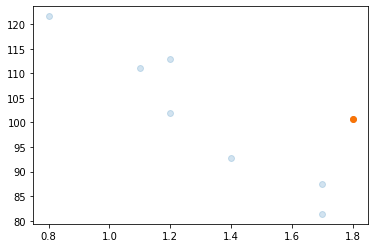

In [82]:
best_scores = anysunday.powercalcs.pick_power_calculator(powers, schedule, best_pick)
best_point = [min(best_scores), sum(best_scores)]

f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.2)

ax.scatter(*best_point, color="xkcd:orange")

(<Figure size 576x720 with 2 Axes>,
 <AxesSubplot:xlabel='Week', ylabel='Pick to Win'>)

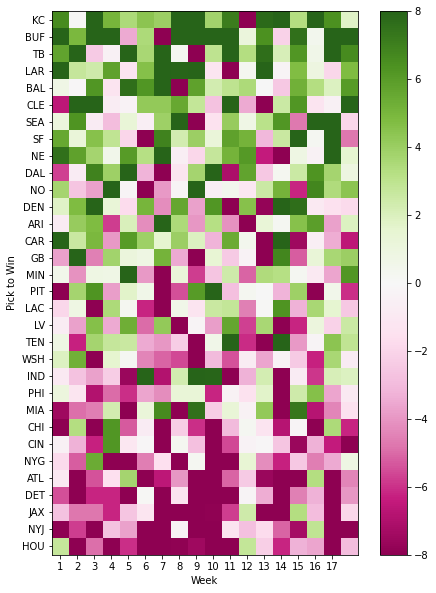

In [83]:
power_rank, matrix = anysunday.powercalcs.pick_grid(powers, schedule, home_bump=3)

viz.plot_matrix(matrix, power_rank)

In [88]:
class PickModes(enum.Enum):
    BEST = "best"
    RANDOM = "random"
    RANDOM_BIASED = "random_biased"


class PickPermuter:
    def __init__(self, powers, schedule, home_bump=HOME_POWER_BUMP, past_picks=None):
        self.powers = powers
        
        self.schedule = schedule
        self.home_bump = home_bump
        
        self.update_pick_grid()
        
        if past_picks is None:
            self.past_picks = []
        else:
            self.past_picks = list(past_picks)
        
        self.pick = self.greedy()
                
    def update_pick_grid(self):
        self.grid_index, self.grid = anysunday.powercalcs.pick_grid(self.powers, self.schedule, self.home_bump)

    def __repr__(self):
        score = self.pick_score
#         return "<{}\n {}\n {}\n min={}, avg={}, max={}>".format(
        return "<{}\n {}\n min={}, avg={}, max={}>".format(
            self.__class__.__name__,
            ", ".join(f"{p:>2s}" for p in self.pick),
#             ", ".join(f"{p:>5s}" for p in self.pick),
#             ", ".join(f"{s:>+4.1f}" for s in score),
            min(self.pick_score),
            statistics.mean(self.pick_score),
            max(self.pick_score),
        )

    def _make_pick(self, week, exclusions=None, mode=PickModes.BEST):
        if exclusions is None:
            exclusions = set()
            
        if mode is PickModes.BEST:
            picks = sorted(list(zip(week, self.grid_index)), reverse=True)
        elif mode is PickModes.RANDOM:
            picks = list(zip(week, self.grid_index))
            random.shuffle(picks)
        elif mode is PickModes.RANDOM_BIASED:
            picks = list(zip(week, self.grid_index))
            random.shuffle(picks)
        else:
            raise ValueError("unknown pick mode")
        for _score, pick in picks:
            if pick in exclusions:
                continue
            return pick    
        raise RuntimeError("no valid pick")
    
    def random(self):
        picks = self.past_picks[:] + [None] * (NUM_WEEKS - len(self.past_picks))
        n_weeks = list(range(len(self.past_picks), NUM_WEEKS))
        random.shuffle(n_weeks)
        for n_week in n_weeks:
            week = self.grid[n_week]
            pick = self._make_pick(week, exclusions=picks, mode=PickModes.RANDOM)
            picks[n_week] = pick
        return picks

    def greedy(self):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            pick = self._make_pick(week, exclusions=picks)
            picks.append(pick)
        assert len(picks) == len(self.grid) == 17
        return picks
    
    def reverse_greedy(self):
        picks = []
        for week in reversed(self.grid[len(self.past_picks):]):
            pick = self._make_pick(week, exclusions=picks + self.past_picks)
            picks.append(pick)
        picks = self.past_picks + picks[::-1]
        assert len(picks) == len(self.grid) == NUM_WEEKS
        return picks
    
    def random_greedy(self):
        picks = self.past_picks[:] + [None] * (NUM_WEEKS - len(self.past_picks))
        n_weeks = list(range(len(self.past_picks), NUM_WEEKS))
        random.shuffle(n_weeks)
        for n_week in n_weeks:
            week = self.grid[n_week]
            pick = self._make_pick(week, exclusions=picks)
            picks[n_week] = pick
        return picks

    def limited_greedy(self, limit=10):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            worst_picks = sorted(list(zip(week, self.grid_index)))
            pivot_index = bisect.bisect_left(worst_picks, (limit, "X"))
            order = (worst_picks[pivot_index:] + list(reversed(worst_picks[:pivot_index])))
            for _score, pick in order:
                if pick not in picks:
                    picks.append(pick)
                    break
            else:
                raise RuntimeError()
        assert len(picks) == len(self.grid) == 17
        return picks
    
#     def greedy_anneal(self):
#         picks = self.greedy()
    
    @property
    def pick_score(self):
        return pick_power_calculator(self.powers, self.schedule, self.pick, home_power=self.home_bump)
    
    def describe_pick(self):
        pick_power_calculator(
            self.powers, self.schedule, self.pick, 
            home_power=self.home_bump, 
            verbose=True, 
            ignore_weeks=len(self.past_picks),
        )
        
    @property
    def fitness(self):
#         return sum(score * k for score, k in zip(heapq.nsmallest(3, self.pick_score), [10, 3, 1]))
        return sum(score * 2**n for n, score in enumerate(sorted(self.pick_score, reverse=True)))

In [104]:
my_past_picks = [
    "LAR",  # week 1
    "NYJ", # week 2
]

tuned_home_bump = 1.5

ppkwargs = {
    "powers": powers,
    "schedule": schedule,
    "home_bump": tuned_home_bump,
    "past_picks": my_past_picks
}

In [92]:
pp = PickPermuter(**ppkwargs)

pprev = PickPermuter(**ppkwargs)
pprev.pick = pprev.reverse_greedy()

pprand = PickPermuter(**ppkwargs)
pprand.pick = pprand.random_greedy()

pplg = PickPermuter(**ppkwargs)
pplg.pick = pplg.limited_greedy(limit=8)

AssertionError: 

In [41]:
pp.describe_pick()

week 16: diff  +8.2 - picking NO  (+7.0+H) over MIN (+0.3  )
week 17: diff +12.0 - picking NE  (+1.7+H) over NYJ (-8.8  )


In [42]:
pprev.describe_pick()

week 16: diff  +8.2 - picking NO  (+7.0+H) over MIN (+0.3  )
week 17: diff +12.0 - picking NE  (+1.7+H) over NYJ (-8.8  )


In [43]:
pprand.describe_pick()

week 16: diff  +8.2 - picking NO  (+7.0+H) over MIN (+0.3  )
week 17: diff +12.0 - picking NE  (+1.7+H) over NYJ (-8.8  )


In [44]:
pplg.describe_pick()

week 16: diff  +8.2 - picking NO  (+7.0+H) over MIN (+0.3  )
week 17: diff +12.0 - picking NE  (+1.7+H) over NYJ (-8.8  )


In [35]:
best_picks = []
best_fitness = -100
for n in range(100_000):
    pprand.pick = pprand.random_greedy()
    
    if pprand.fitness > best_fitness:
        print("new best fitness", int(pprand.fitness))
        best_picks = pprand.pick
        best_fitness = pprand.fitness
        
pprand.pick = best_picks
pprand.describe_pick()

new best fitness 281155
week 14: diff +13.5 - picking SEA (+3.2+H) over NYJ (-8.8  )
week 15: diff  +9.9 - picking SF  (+3.5  ) over DAL (-7.9+H)
week 16: diff +11.1 - picking BAL (+5.9+H) over NYG (-3.7  )
week 17: diff +12.0 - picking NE  (+1.7+H) over NYJ (-8.8  )


In [36]:
best_picks = []
best_fitness = -100
for n in range(2_000_000):
    pprand.pick = pprand.random()
    
    try:
        if pprand.fitness > best_fitness:
            print("new best fitness", int(pprand.fitness))
            best_picks = pprand.pick
            best_fitness = pprand.fitness
    except ValueError:
        continue
        
pprand.pick = best_picks
pprand.describe_pick()

new best fitness 104447
new best fitness 138364
new best fitness 163778
new best fitness 186447
new best fitness 234960
new best fitness 254204
new best fitness 273648
new best fitness 281129
new best fitness 281155
week 14: diff +13.5 - picking SEA (+3.2+H) over NYJ (-8.8  )
week 15: diff  +9.9 - picking SF  (+3.5  ) over DAL (-7.9+H)
week 16: diff +11.1 - picking BAL (+5.9+H) over NYG (-3.7  )
week 17: diff +12.0 - picking NE  (+1.7+H) over NYJ (-8.8  )


## FiveThirtyEight Elo Data

* Links
    * https://projects.fivethirtyeight.com/2020-nfl-predictions/
    * https://github.com/fivethirtyeight/data/tree/master/nfl-elo
* Important Fields
    * `team1`	Abbreviation for home team
    * `team2`	Abbreviation for away team
    * `qbelo_prob1`	Home team's probability of winning according to quarterback-adjusted Elo
    * `qbelo_prob2`	Away team's probability of winning according to quarterback-adjusted Elo

In [95]:
data = anysunday.loaders.five38_elos()

In [96]:
data.shape

(272, 33)

In [22]:
data

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,2021-09-09,2021,0,NaN,TB,DAL,1656.235930,1452.424236,0.824539,0.175461,...,397.401725,223.782352,248.082791,1639.815956,1500.264612,31.0,29.0,85,48,67
1,2021-09-12,2021,0,NaN,IND,SEA,1561.490084,1565.751134,0.586531,0.413469,...,246.652318,113.888998,192.992819,1500.541394,1580.083300,16.0,28.0,63,73,68
2,2021-09-12,2021,0,NaN,TEN,ARI,1553.397217,1486.436956,0.681272,0.318728,...,302.017311,190.370826,225.696909,1489.651053,1528.361042,13.0,38.0,56,59,58
3,2021-09-12,2021,0,NaN,CIN,MIN,1412.119826,1494.522721,0.474976,0.525024,...,283.256583,154.384747,208.346744,1441.243406,1487.591981,27.0,24.0,33,57,45
4,2021-09-12,2021,0,NaN,HOU,JAX,1432.775542,1339.023563,0.713787,0.286213,...,82.479069,137.164623,109.859329,1391.718434,1350.757949,37.0,21.0,0,17,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2022-01-09,2021,0,NaN,HOU,TEN,1405.664465,1527.353584,0.419134,0.580866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,50,29
268,2022-01-09,2021,0,NaN,ARI,SEA,1538.073811,1575.511783,0.539582,0.460418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,97,87
269,2022-01-09,2021,0,NaN,LAR,SF,1603.515387,1531.424468,0.687651,0.312349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88,83,86
270,2022-01-09,2021,0,NaN,DEN,KC,1497.591901,1644.239651,0.384616,0.615384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90,86,88


In [100]:
import dateutil.parser

WEEK_1_WED = datetime.datetime(year=2021, month=9, day=9)
TEAM_RENAMES = {
    "OAK": "LV",  # Raiders
}

def date_to_week(date):
    if not isinstance(date, datetime.datetime):
        date = dateutil.parser.parse(date)
    day_diff = (date - WEEK_1_WED) / datetime.timedelta(days=1)
    return int((day_diff // 7) + 1)

def pick_grid_538(data):
    powers = {}
    matches = []
    for _index, row in data.iterrows():
        week = date_to_week(row["date"])
        if week > NUM_WEEKS: 
            break
        for n in "12":
            team = row[f"team{n}"]
            elo = row[f"qbelo{n}_post"]
            p_win = row[f"qbelo_prob{n}"]
            if not math.isnan(elo):
                powers[team] = elo
            matches.append((team, week, p_win))

    index = sorted(powers, key=lambda t: powers[t])
    matrix = [[-10] * NUM_TEAMS for _ in range(NUM_WEEKS)]
    for team, week, p_win in matches:
        matrix[week - 1][index.index(team)] = 20 * (p_win - 0.5)
    
    # 538 uses old names as they have historical(ish) data
    index = [TEAM_RENAMES.get(n, n) for n in index]
    return index, matrix

(<Figure size 576x720 with 2 Axes>,
 <AxesSubplot:xlabel='Week', ylabel='Pick to Win'>)

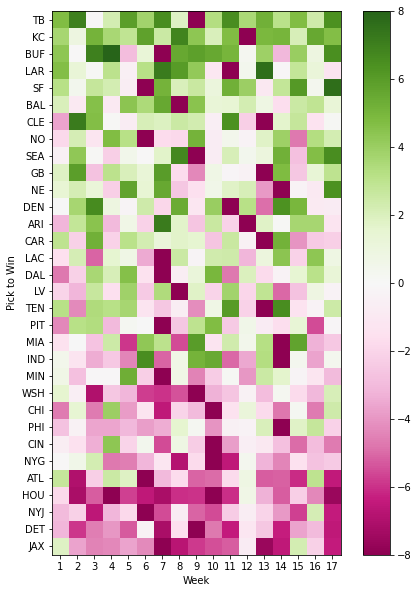

In [101]:
index538, matrix538 = pick_grid_538(data)
viz.plot_matrix(matrix538, index538)

In [105]:
class ProbPickPermuter(PickPermuter):
    def __init__(self, df, past_picks=None):
        self.past_picks = past_picks or []
        
        self.df = df.copy()
        self.df["week"] = self.df["date"].apply(date_to_week)
        
        # ignore postseason games
        self.df = self.df[self.df["week"] <= NUM_WEEKS]
    
        self.grid_index, self.grid = pick_grid_538(self.df)
        
        self.pick = self.greedy()

    @property
    def pick_score(self):
        scores = []
        for week in range(NUM_WEEKS):
            pick = self.pick[week]
            pick_index = self.grid_index.index(pick)
            scores.append(self.grid[week][pick_index])
        return scores

In [106]:
ppp = ProbPickPermuter(data, past_picks=my_past_picks)
ppp.pick = ppp.greedy()
ppp.fitness

95299.85024082713

In [109]:
ppp = ProbPickPermuter(data, past_picks=my_past_picks)

best_538_picks = []
best_538_fitness = -100
for n in range(10_000_000):
    ppp.pick = ppp.random_greedy()
    
    if ppp.fitness > best_538_fitness:
        print("new best fitness", int(ppp.fitness))
        best_538_picks = ppp.pick
        print(" ".join(format(p, ">3s") for p in best_538_picks))
        best_538_fitness = ppp.fitness
        
ppp.pick = best_538_picks
ppp.pick 

new best fitness 112310
LAR NYJ DEN  NO  NE IND ARI  KC MIA DAL CLE  TB BUF TEN  SF LAC SEA
new best fitness 112539
LAR NYJ BUF  NO  TB BAL ARI DEN IND DAL CLE  SF  KC TEN MIA SEA  NE
new best fitness 137615
LAR NYJ BUF  NO  NE IND ARI  KC MIA DAL CLE  SF  TB TEN DEN LAC SEA
new best fitness 138369
LAR NYJ BUF  NO  TB IND ARI DEN BAL DAL CLE  SF  KC TEN MIA SEA  NE
new best fitness 139613
LAR NYJ DEN BUF  NE IND ARI  KC  NO DAL CLE  SF  TB TEN MIA LAC SEA
new best fitness 140113
LAR NYJ DEN  NO  NE IND ARI SEA BAL DAL CLE  SF  TB TEN MIA  KC BUF
new best fitness 140606
LAR NYJ DEN  NO MIN IND ARI SEA BAL BUF CLE  SF  TB TEN MIA  KC  NE
new best fitness 144247
LAR NYJ DEN BUF MIN IND ARI  KC  NO DAL CLE  SF  TB TEN MIA SEA  NE
new best fitness 147986
LAR NYJ CAR BUF  NE IND ARI DEN  NO DAL CLE  SF  TB TEN MIA  KC SEA
new best fitness 148298
LAR NYJ DEN BUF MIN IND ARI SEA  NO DAL CLE  SF  TB TEN MIA  KC  NE


['LAR',
 'NYJ',
 'DEN',
 'BUF',
 'MIN',
 'IND',
 'ARI',
 'SEA',
 'NO',
 'DAL',
 'CLE',
 'SF',
 'TB',
 'TEN',
 'MIA',
 'KC',
 'NE']

In [108]:
print(" ".join(format(p, ">3s") for p in pprand.pick))
print(" ".join(format(p, ">3s") for p in best_538_picks))

NameError: name 'pprand' is not defined